# Regression using the Sinkhorn kernel

This notebooks performs regression on the Rotor37 dataset using the Sinkhorn kernel. The potentials are computed elsewhere and imported in this notebook.

This notebook also present the evolution of the regression performances with regard to numerous hyperparameters.

The results are not matching the one in the paper because in the paper we used 24 random starts and therefore achieved better results.

<br>

Authors of this notebook:
* Louis Allain
* Léonard Gousset
* Julien Heurtin

In [25]:
from packages import *
import importing
import matplotlib.pyplot as plt
import numpy as np
from GPy.kern import Matern52
from GPy.kern import RBF

from GPy.models.gp_regression import GPRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import kernels

# Set the seed for reproducibility
np.random.seed(42)

## Define train and test splits possible.
train8 = [154,174,383,501,524,593,711,732]
train16 = [76,124,130,154,157,174,383,501,524,593,711,732,798,800,959,987]
train32 = [3,23,76,124,130,154,157,174,190,316,324,339,383,469,501,524,556,593,606,616,662,673,711,732,757,798,800,846,909,927,959,987]
train64 = [3,23,34,56,71,76,124,130,145,154,157,174,187,190,201,210,223,288,316,324,335,339,376,379,383,389,414,444,469,490,501,519,524,556,557,572,575,589,593,606,616,662,673,692,711,732,741,757,760,772,781,782,798,800,806,836,846,852,896,909,927,959,985,987]
train125 = [3,6,16,20,23,34,56,71,76,78,83,102,105,124,130,145,152,154,157,160,173,174,180,187,190,198,201,204,210,223,224,229,233,251,278,288,289,316,317,324,335,339,371,375,376,377,379,383,389,414,426,428,431,443,444,463,469,471,490,501,513,516,519,524,525,527,530,556,557,558,572,573,575,589,593,606,612,616,624,628,638,662,673,681,692,699,711,713,715,732,741,754,757,760,763,769,772,779,781,782,783,784,798,800,806,812,834,836,843,846,852,854,866,872,877,896,909,927,931,939,956,959,985,987,996]
train250 = [3,6,7,16,20,21,22,23,29,33,34,39,46,56,57,71,76,77,78,81,83,95,99,101,102,105,115,117,124,130,143,145,152,154,157,159,160,167,173,174,180,182,187,190,196,198,201,203,204,210,212,217,220,223,224,229,233,246,247,250,251,252,264,268,270,278,288,289,300,312,314,316,317,319,320,324,334,335,337,339,348,356,357,359,367,369,370,371,375,376,377,379,383,389,395,396,398,400,404,405,408,413,414,415,416,420,426,428,431,435,436,441,443,444,449,452,463,468,469,471,472,479,483,490,501,512,513,516,518,519,523,524,525,526,527,528,530,532,553,556,557,558,561,567,568,570,572,573,575,589,593,595,597,601,606,612,616,621,622,624,628,629,631,638,641,643,647,648,657,662,663,673,677,681,692,699,703,704,705,711,713,715,721,728,731,732,741,742,747,754,757,760,763,766,769,772,779,781,782,783,784,798,800,806,812,813,816,823,826,832,833,834,836,842,843,846,852,854,857,864,866,871,872,876,877,884,892,896,901,909,922,927,931,936,937,939,946,956,959,965,975,978,982,985,987,993,994,995,996,999]
train500 = [1,2,3,6,7,9,11,14,16,18,20,21,22,23,26,29,31,32,33,34,36,37,38,39,44,46,48,51,52,54,55,56,57,58,59,61,62,66,67,71,72,73,76,77,78,80,81,82,83,86,89,92,94,95,99,101,102,105,109,111,113,115,117,118,123,124,129,130,136,140,143,144,145,152,153,154,155,157,159,160,164,167,168,173,174,176,177,180,182,187,188,190,192,193,194,196,198,199,201,202,203,204,206,207,210,211,212,213,217,219,220,221,223,224,227,228,229,233,234,237,239,240,244,245,246,247,249,250,251,252,255,263,264,266,268,269,270,271,272,277,278,284,288,289,291,293,300,302,303,312,314,316,317,319,320,323,324,329,331,332,334,335,337,339,348,351,353,356,357,359,361,363,364,366,367,369,370,371,373,375,376,377,379,380,382,383,384,387,389,390,395,396,398,400,403,404,405,408,411,412,413,414,415,416,417,418,419,420,421,426,428,429,431,433,435,436,437,438,439,441,442,443,444,445,447,448,449,450,452,456,463,464,465,467,468,469,471,472,473,476,477,479,481,482,483,485,486,487,489,490,491,494,495,496,497,501,502,506,508,509,510,512,513,514,515,516,518,519,523,524,525,526,527,528,529,530,532,548,550,552,553,556,557,558,560,561,567,568,570,572,573,574,575,578,581,582,583,589,591,592,593,595,596,597,601,605,606,610,612,613,614,616,617,618,621,622,624,626,628,629,631,633,635,638,641,643,647,648,650,652,654,657,658,662,663,667,668,670,673,677,678,681,688,690,692,693,696,699,703,704,705,706,707,711,713,715,719,721,722,724,728,729,731,732,736,741,742,745,746,747,753,754,757,760,761,763,764,765,766,767,768,769,770,771,772,773,775,778,779,780,781,782,783,784,787,789,794,795,798,800,802,804,806,808,811,812,813,815,816,818,819,823,826,827,829,832,833,834,836,842,843,846,847,849,852,853,854,855,856,857,859,861,862,863,864,866,870,871,872,873,876,877,880,882,884,887,888,891,892,893,894,896,898,900,901,902,906,909,914,920,921,922,925,927,931,936,937,938,939,942,946,950,951,952,955,956,957,959,964,965,966,969,972,975,978,980,981,982,983,985,986,987,988,989,990,993,994,995,996,999]
train1000 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999]
test = [1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199]

## Influence of hyperparameters on time

#### Espilon

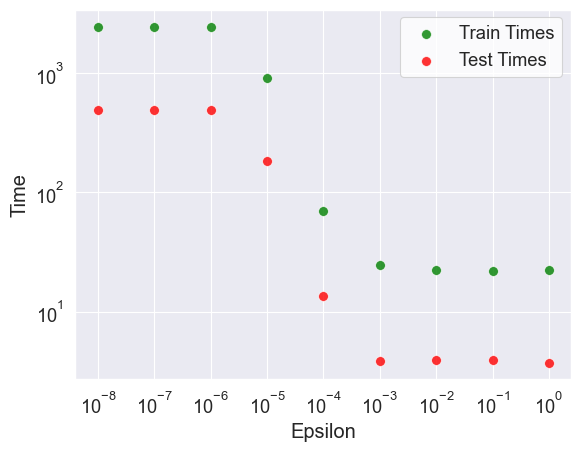

In [7]:
all_epsilons = [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08]
train_times = []
test_times = []
for epsilon in all_epsilons:
        metadata_path = f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_metadata_train1000_NoSubsample_29773_epsilon_{epsilon}_disk_1000_cut_1_1.json"
        with open(metadata_path) as f:
                metadata = json.load(f)

        train_times.append(metadata["sinkhorn"]["train_time"])
        test_times.append(metadata["sinkhorn"]["test_time"])

# plot
plt.figure()
sns.set_theme(context='paper', font_scale=1.5)
blue_palette = sns.color_palette("Greens")

sns.scatterplot(x = all_epsilons, y = train_times, color="green", s=50, alpha=0.8, label="Train Times")
sns.scatterplot(x = all_epsilons, y = test_times, color="red", s=50, alpha=0.8, label="Test Times")

plt.xscale('log')
plt.yscale("log")
plt.ylabel("Time")
plt.xlabel('Epsilon')
legend = plt.legend(bbox_to_anchor=(0.98, 0.98), borderaxespad=0)
legend.get_frame().set_facecolor('white')  # Set legend background color to white

plt.show()

### Reference mesure size

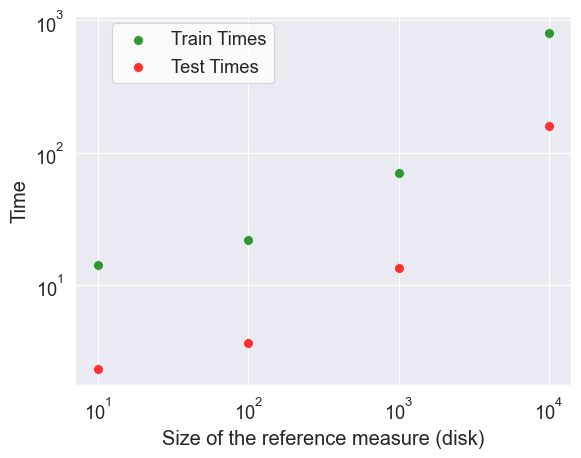

In [10]:
all_ref_sizes = [10, 100, 1000, 10000]
train_times = []
test_times = []
for size in all_ref_sizes:
        metadata_path = f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_metadata_train1000_NoSubsample_29773_epsilon_0.0001_disk_{size}_cut_1_1.json"
        with open(metadata_path) as f:
                metadata = json.load(f)

        train_times.append(metadata["sinkhorn"]["train_time"])
        test_times.append(metadata["sinkhorn"]["test_time"])

# plot
plt.figure()
sns.set_theme(context='paper', font_scale=1.5)
blue_palette = sns.color_palette("Greens")

sns.scatterplot(x = all_ref_sizes, y = train_times, color="green", s=50, alpha=0.8, label="Train Times")
sns.scatterplot(x = all_ref_sizes, y = test_times, color="red", s=50, alpha=0.8, label="Test Times")

plt.xscale('log')
plt.yscale("log")
plt.ylabel("Time")
plt.xlabel('Size of the reference measure (disk)')
legend = plt.legend(bbox_to_anchor=(0.4, 0.98), borderaxespad=0)
legend.get_frame().set_facecolor('white')  # Set legend background color to white

plt.show()

### Subsampling size

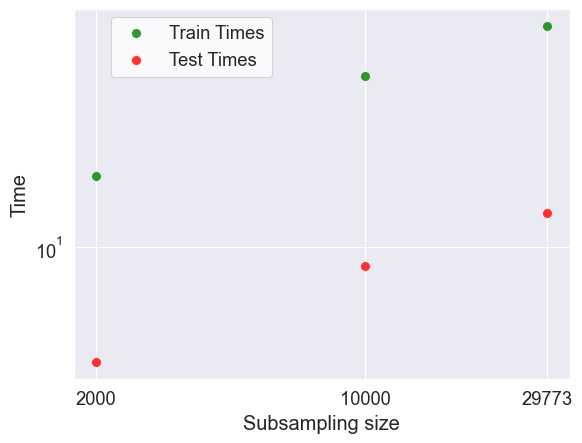

In [9]:
all_sub_sizes = [2000, 10000]
train_times = []
test_times = []
for size in all_sub_sizes:
        metadata_path = f"Save_Sinkhorn/train1000/OneRandom/{size}/sinkhorn_metadata_train1000_OneRandom_{size}_epsilon_0.0001_disk_1000_cut_1_1.json"
        with open(metadata_path) as f:
                metadata = json.load(f)

        train_times.append(metadata["sinkhorn"]["train_time"])
        test_times.append(metadata["sinkhorn"]["test_time"])

all_sub_sizes.append(29773)
metadata_path = f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_metadata_train1000_NoSubsample_29773_epsilon_0.0001_disk_1000_cut_1_1.json"
with open(metadata_path) as f:
        metadata = json.load(f)
train_times.append(metadata["sinkhorn"]["train_time"])
test_times.append(metadata["sinkhorn"]["test_time"])


# plot
plt.figure()
sns.set_theme(context='paper', font_scale=1.5)
blue_palette = sns.color_palette("Greens")

sns.scatterplot(x = all_sub_sizes, y = train_times, color="green", s=50, alpha=0.8, label="Train Times")
sns.scatterplot(x = all_sub_sizes, y = test_times, color="red", s=50, alpha=0.8, label="Test Times")

plt.xscale('log')
plt.yscale("log")
plt.ylabel("Time")
plt.xlabel('Subsampling size')
legend = plt.legend(bbox_to_anchor=(0.4, 0.98), borderaxespad=0)
legend.get_frame().set_facecolor('white')  # Set legend background color to white
plt.xticks(all_sub_sizes, all_sub_sizes)

plt.show()

## Hyperparameter: Epsilon

In [ ]:
pca_components = 32
epsilon_values = []
evs_values = []
all_epsilons = [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08]

for epsilon in all_epsilons:
    # load training data
    x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)

    potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_{epsilon}_disk_1000_cut_1_1.npy")

    #train_data = load_data_fn(split="train")
    #x_scalars = train_data["x_scalars"]
    #y_train = train_data["y_scalars"]
    #potentials_train = np.load(f"potentials_train_epsilon_{epsilon}_ref_blade0.npy")

    # dimensionality reduction
    pca = PCA(n_components = pca_components)
    X_train_pca = pca.fit_transform(potentials_train)

    # define transformed inputs
    X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train)

    # load test data and transform
    x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
    potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_{epsilon}_disk_1000_cut_1_1.npy")


    #x_scalars = test_data["x_scalars"]
    #y_test = test_data["y_scalars"]

    X_test_pca = pca.transform(potentials_test)
    X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
    X_test_ = scaler.transform(X_test)

    # train Gaussian process
    kernel_sinkhorn = Matern52(input_dim = pca_components, active_dims = np.arange(2, pca_components+2), ARD = False)
    kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
    kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
    kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
    print(f"Start GP training! With epsilon: {epsilon}.")
    kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

    # predict
    y_pred, _ = kmodel.predict(X_test_)
    evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

    epsilon_values.append(epsilon)
    evs_values.append(evs)

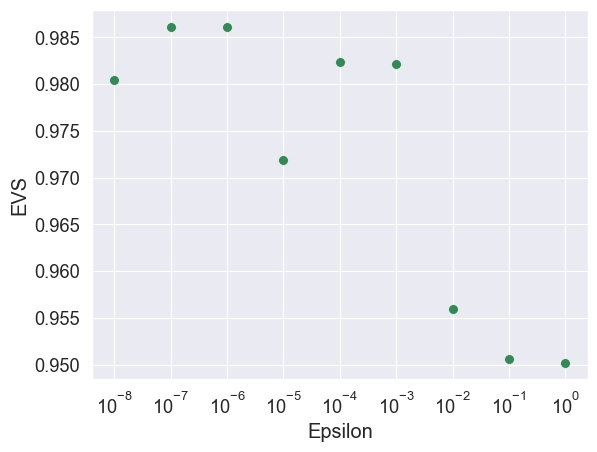

In [3]:
# plot
plt.figure()
sns.set_theme(context='paper', font_scale=1.5)
blue_palette = sns.color_palette("Greens")
sns.scatterplot(x = epsilon_values, y = evs_values, color=blue_palette[5], s=50, alpha=0.8)

plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('EVS')
#plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.show()

## Hyperparameter: Subsampling method

In [ ]:
pca_components = 32
subsampled_method_values = []
evs_values = []
all_subsampled = ["OneRandom", "MultipleRandom", "Optimized"]

for subsampled_method in all_subsampled:
    # load training data
    x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)

    potentials_train = np.load(f"Save_Sinkhorn/train1000/"+subsampled_method+"/2000/sinkhorn_potentials_train1000_"+subsampled_method+"_2000_epsilon_0.0001_disk_1000_cut_1_1.npy")

    #train_data = load_data_fn(split="train")
    #x_scalars = train_data["x_scalars"]
    #y_train = train_data["y_scalars"]
    #potentials_train = np.load(f"potentials_train_epsilon_{epsilon}_ref_blade0.npy")

    # dimensionality reduction
    pca = PCA(n_components = pca_components)
    X_train_pca = pca.fit_transform(potentials_train)

    # define transformed inputs
    X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train)

    # load test data and transform
    x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
    potentials_test = np.load(f"Save_Sinkhorn/train1000/"+subsampled_method+"/2000/sinkhorn_potentials_test_train1000_"+subsampled_method+"_2000_epsilon_0.0001_disk_1000_cut_1_1.npy")

    X_test_pca = pca.transform(potentials_test)
    X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
    X_test_ = scaler.transform(X_test)

    # train Gaussian process
    kernel_sinkhorn = Matern52(input_dim = pca_components, active_dims = np.arange(2, pca_components+2), ARD = False)
    kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
    kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
    kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
    print(f"Start GP training! With {subsampled_method}.")
    kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

    # predict
    y_pred, _ = kmodel.predict(X_test_)
    evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

    subsampled_method_values.append(subsampled_method)
    evs_values.append(evs)

In [15]:
print("All subsample methods:", subsampled_method_values)
print("Corresponding EVS:", evs_values)

All subsample methods: ['OneRandom', 'MultipleRandom', 'Optimized']
Corresponding EVS: [0.9785975691236259, -0.007936346462620536, 0.5848889797879371]


## Hyperparameter: Reference measure and its size

In [ ]:
pca_components = 32
evs_values = []
all_refmeasuresize = [10, 100, 1000, 10000]
all_refmeasure = ["disk", "sphere"]
sizes_values = []
ref_values = []

for refmeasure in all_refmeasure:
    for size in all_refmeasuresize:
        # load training data
        x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)

        potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_0.0001_{refmeasure}_{size}_cut_1_1.npy")

        #train_data = load_data_fn(split="train")
        #x_scalars = train_data["x_scalars"]
        #y_train = train_data["y_scalars"]
        #potentials_train = np.load(f"potentials_train_epsilon_{epsilon}_ref_blade0.npy")

        # dimensionality reduction
        pca = PCA(n_components = pca_components)
        X_train_pca = pca.fit_transform(potentials_train)

        # define transformed inputs
        X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
        scaler = StandardScaler()
        X_train_ = scaler.fit_transform(X_train)

        # load test data and transform
        #test_data = load_data_fn(split="test")
        x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
        potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_0.0001_{refmeasure}_{size}_cut_1_1.npy")


        X_test_pca = pca.transform(potentials_test)
        X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
        X_test_ = scaler.transform(X_test)

        # train Gaussian process
        kernel_sinkhorn = Matern52(input_dim = pca_components, active_dims = np.arange(2, pca_components+2), ARD = False)
        kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
        kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
        kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
        print(f"Start GP training! With {refmeasure} and {size}.")
        kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

        # predict
        y_pred, _ = kmodel.predict(X_test_)
        evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

        ref_values.append(refmeasure)
        evs_values.append(evs)
        sizes_values.append(size)






# load training data
x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)
potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_0.0001_blade0_29773_cut_1_1.npy ")

# dimensionality reduction
pca = PCA(n_components = pca_components)
X_train_pca = pca.fit_transform(potentials_train)

# define transformed inputs
X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)

# load test data and transform
#test_data = load_data_fn(split="test")
x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_0.0001_blade0_29773_cut_1_1.npy ")


#x_scalars = test_data["x_scalars"]
#y_test = test_data["y_scalars"]

X_test_pca = pca.transform(potentials_test)
X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
X_test_ = scaler.transform(X_test)

# train Gaussian process
kernel_sinkhorn = Matern52(input_dim = pca_components, active_dims = np.arange(2, pca_components+2), ARD = False)
kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
print(f"Start GP training! With full blades.")
kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

# predict
y_pred, _ = kmodel.predict(X_test_)
evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)


ref_values.append("blade0")
evs_values.append(evs)
sizes_values.append(29773)

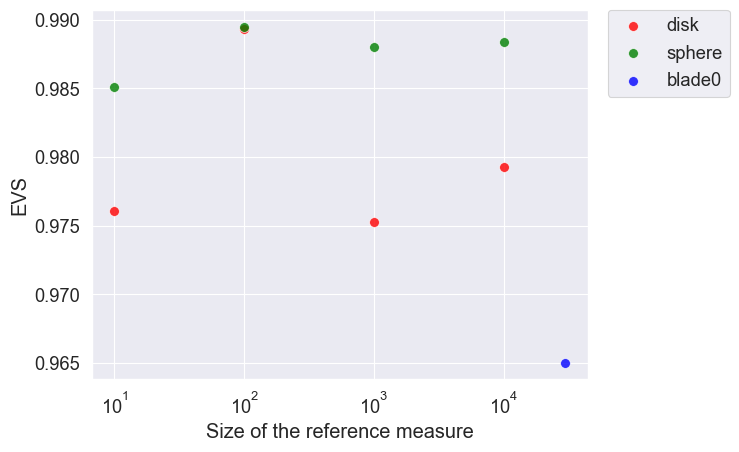

In [19]:
all_refmeasure = ["disk", "sphere", "blade0"]
plt.figure()
sns.set_theme(context='paper', font_scale=1.5)

colors = ['red', 'green', "blue"]
for i, measure in enumerate(all_refmeasure):
    indices = [j for j, label in enumerate(ref_values) if label == measure]
    sns.scatterplot(x = [sizes_values[j] for j in indices], y = [evs_values[j] for j in indices], color=colors[i], s=50, alpha=0.8, label=measure)

plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Size of the reference measure')
plt.ylabel('EVS')
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

plt.show()

## Hyperparameter: Train split

In [ ]:
pca_components = 32
epsilon_values = []
evs_values = []
all_refmeasuresize = ["train8", "train16", "train32", "train64", "train125", "train250", "train500", "train1000"]

train_list = {"train8": [154,174,383,501,524,593,711,732],
                "train16": [76,124,130,154,157,174,383,501,524,593,711,732,798,800,959,987],
                "train32": [3,23,76,124,130,154,157,174,190,316,324,339,383,469,501,524,556,593,606,616,662,673,711,732,757,798,800,846,909,927,959,987]}

for key in train_list:
    # load training data
    x_scalars, y_train = importing.r37_scalars(ids = train_list[key], test = False)

    potentials_train = np.load(f"Save_Sinkhorn/"+key+"/NoSubsample/29773/sinkhorn_potentials_"+key+"_NoSubsample_29773_epsilon_0.0001_disk_1000_cut_1_1.npy")

    # define transformed inputs
    X_train = np.concatenate([x_scalars, potentials_train], axis=1)
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train)

    # load test data and transform
    x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
    potentials_test = np.load(f"Save_Sinkhorn/"+key+"/NoSubsample/29773/sinkhorn_potentials_test_"+key+"_NoSubsample_29773_epsilon_0.0001_disk_1000_cut_1_1.npy")


    #X_test_pca = pca.transform(potentials_test)
    X_test = np.concatenate([x_scalars, potentials_test], axis=1)
    X_test_ = scaler.transform(X_test)

    # train Gaussian process
    kernel_sinkhorn = Matern52(input_dim = pca_components, active_dims = np.arange(2, pca_components+2), ARD = False)
    kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
    kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
    kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
    print(f"Start GP training! With {key}.")
    kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

    # predict
    y_pred, _ = kmodel.predict(X_test_)
    evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

    epsilon_values.append(subsampled_method)
    evs_values.append(evs)

train_list = {"train64": [3,23,34,56,71,76,124,130,145,154,157,174,187,190,201,210,223,288,316,324,335,339,376,379,383,389,414,444,469,490,501,519,524,556,557,572,575,589,593,606,616,662,673,692,711,732,741,757,760,772,781,782,798,800,806,836,846,852,896,909,927,959,985,987],
            "train125": [3,6,16,20,23,34,56,71,76,78,83,102,105,124,130,145,152,154,157,160,173,174,180,187,190,198,201,204,210,223,224,229,233,251,278,288,289,316,317,324,335,339,371,375,376,377,379,383,389,414,426,428,431,443,444,463,469,471,490,501,513,516,519,524,525,527,530,556,557,558,572,573,575,589,593,606,612,616,624,628,638,662,673,681,692,699,711,713,715,732,741,754,757,760,763,769,772,779,781,782,783,784,798,800,806,812,834,836,843,846,852,854,866,872,877,896,909,927,931,939,956,959,985,987,996],
            "train250": [3,6,7,16,20,21,22,23,29,33,34,39,46,56,57,71,76,77,78,81,83,95,99,101,102,105,115,117,124,130,143,145,152,154,157,159,160,167,173,174,180,182,187,190,196,198,201,203,204,210,212,217,220,223,224,229,233,246,247,250,251,252,264,268,270,278,288,289,300,312,314,316,317,319,320,324,334,335,337,339,348,356,357,359,367,369,370,371,375,376,377,379,383,389,395,396,398,400,404,405,408,413,414,415,416,420,426,428,431,435,436,441,443,444,449,452,463,468,469,471,472,479,483,490,501,512,513,516,518,519,523,524,525,526,527,528,530,532,553,556,557,558,561,567,568,570,572,573,575,589,593,595,597,601,606,612,616,621,622,624,628,629,631,638,641,643,647,648,657,662,663,673,677,681,692,699,703,704,705,711,713,715,721,728,731,732,741,742,747,754,757,760,763,766,769,772,779,781,782,783,784,798,800,806,812,813,816,823,826,832,833,834,836,842,843,846,852,854,857,864,866,871,872,876,877,884,892,896,901,909,922,927,931,936,937,939,946,956,959,965,975,978,982,985,987,993,994,995,996,999],
            "train500": [1,2,3,6,7,9,11,14,16,18,20,21,22,23,26,29,31,32,33,34,36,37,38,39,44,46,48,51,52,54,55,56,57,58,59,61,62,66,67,71,72,73,76,77,78,80,81,82,83,86,89,92,94,95,99,101,102,105,109,111,113,115,117,118,123,124,129,130,136,140,143,144,145,152,153,154,155,157,159,160,164,167,168,173,174,176,177,180,182,187,188,190,192,193,194,196,198,199,201,202,203,204,206,207,210,211,212,213,217,219,220,221,223,224,227,228,229,233,234,237,239,240,244,245,246,247,249,250,251,252,255,263,264,266,268,269,270,271,272,277,278,284,288,289,291,293,300,302,303,312,314,316,317,319,320,323,324,329,331,332,334,335,337,339,348,351,353,356,357,359,361,363,364,366,367,369,370,371,373,375,376,377,379,380,382,383,384,387,389,390,395,396,398,400,403,404,405,408,411,412,413,414,415,416,417,418,419,420,421,426,428,429,431,433,435,436,437,438,439,441,442,443,444,445,447,448,449,450,452,456,463,464,465,467,468,469,471,472,473,476,477,479,481,482,483,485,486,487,489,490,491,494,495,496,497,501,502,506,508,509,510,512,513,514,515,516,518,519,523,524,525,526,527,528,529,530,532,548,550,552,553,556,557,558,560,561,567,568,570,572,573,574,575,578,581,582,583,589,591,592,593,595,596,597,601,605,606,610,612,613,614,616,617,618,621,622,624,626,628,629,631,633,635,638,641,643,647,648,650,652,654,657,658,662,663,667,668,670,673,677,678,681,688,690,692,693,696,699,703,704,705,706,707,711,713,715,719,721,722,724,728,729,731,732,736,741,742,745,746,747,753,754,757,760,761,763,764,765,766,767,768,769,770,771,772,773,775,778,779,780,781,782,783,784,787,789,794,795,798,800,802,804,806,808,811,812,813,815,816,818,819,823,826,827,829,832,833,834,836,842,843,846,847,849,852,853,854,855,856,857,859,861,862,863,864,866,870,871,872,873,876,877,880,882,884,887,888,891,892,893,894,896,898,900,901,902,906,909,914,920,921,922,925,927,931,936,937,938,939,942,946,950,951,952,955,956,957,959,964,965,966,969,972,975,978,980,981,982,983,985,986,987,988,989,990,993,994,995,996,999],
            "train1000": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999]
            }

for key in train_list:
    # load training data
    x_scalars, y_train = importing.r37_scalars(ids = train_list[key], test = False)

    potentials_train = np.load(f"Save_Sinkhorn/"+key+"/NoSubsample/29773/sinkhorn_potentials_"+key+"_NoSubsample_29773_epsilon_0.0001_disk_1000_cut_1_1.npy")
    
    # dimensionality reduction
    pca = PCA(n_components = pca_components)
    X_train_pca = pca.fit_transform(potentials_train)

    # define transformed inputs
    X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train)

    # load test data and transform
    x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
    potentials_test = np.load(f"Save_Sinkhorn/"+key+"/NoSubsample/29773/sinkhorn_potentials_test_"+key+"_NoSubsample_29773_epsilon_0.0001_disk_1000_cut_1_1.npy")


    X_test_pca = pca.transform(potentials_test)
    X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
    X_test_ = scaler.transform(X_test)

    # train Gaussian process
    kernel_sinkhorn = Matern52(input_dim = pca_components, active_dims = np.arange(2, pca_components+2), ARD = False)
    kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
    kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
    kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
    print(f"Start GP training! With {key}.")
    kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

    # predict
    y_pred, _ = kmodel.predict(X_test_)
    evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

    epsilon_values.append(subsampled_method)
    evs_values.append(evs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


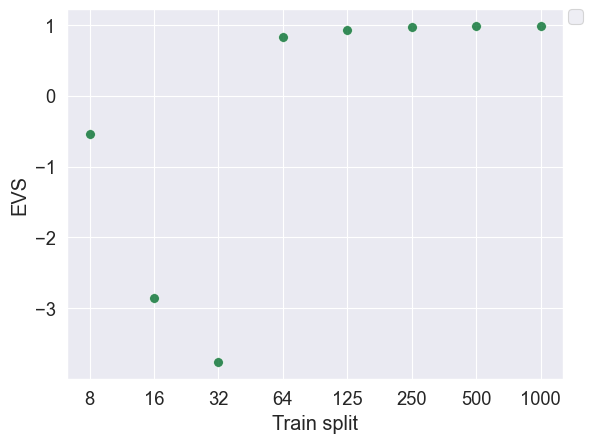

In [21]:
# plot
all_refmeasuresize = ["8", "16", "32", "64", "125", "250", "500", "1000"]

plt.figure()
sns.set_theme(context='paper', font_scale=1.5)
blue_palette = sns.color_palette("Greens")

sns.scatterplot(x = all_refmeasuresize, y = evs_values, color=blue_palette[5], s=50, alpha=0.8)

plt.xlabel('Train split')
plt.ylabel('EVS')
plt.xticks(ticks=range(len(all_refmeasuresize)), labels=all_refmeasuresize)

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.savefig(f"Images/trainSplit_vs_evs.png", bbox_inches="tight", format = "png", dpi = 400)
plt.show()

## Hyperparameter: PCA components

In [ ]:
pca_components = [4, 8, 16, 24, 32, 40, 48]
pca_values = []
evs_values = []

for pca_dim in pca_components:
    # load training data
    x_scalars, y_train = importing.r37_scalars(ids = train_list[key], test = False)

    potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_0.0001_sphere_100_cut_1_1.npy")

    # dimensionality reduction
    pca = PCA(n_components = pca_dim)
    X_train_pca = pca.fit_transform(potentials_train)

    # define transformed inputs
    X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train)

    # load test data and transform
    #test_data = load_data_fn(split="test")
    x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
    potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_0.0001_sphere_100_cut_1_1.npy")


    X_test_pca = pca.transform(potentials_test)
    X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
    X_test_ = scaler.transform(X_test)

    # train Gaussian process
    kernel_sinkhorn = Matern52(input_dim = pca_dim, active_dims = np.arange(2, pca_dim+2), ARD = False)
    kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
    kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
    kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
    print(f"Start GP training! With {key}.")
    kmodel.optimize_restarts(num_restarts = 24, messages = False, max_iters = 10000)

    # predict
    y_pred, _ = kmodel.predict(X_test_)
    evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

    pca_values.append(pca_dim)
    evs_values.append(evs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


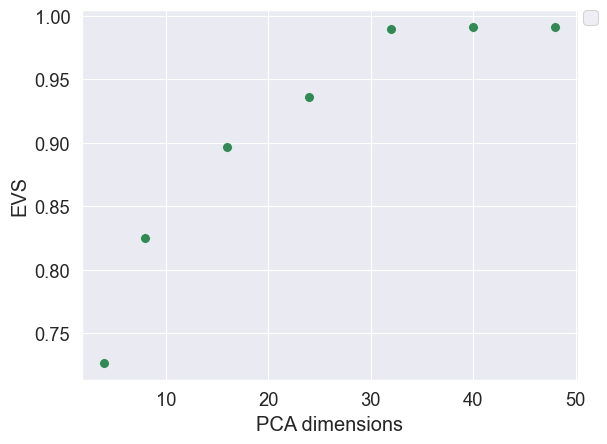

In [23]:
# plot
plt.figure()
sns.set_theme(context='paper', font_scale=1.5)
blue_palette = sns.color_palette("Greens")

sns.scatterplot(x = pca_values, y = evs_values, color=blue_palette[5], s=50, alpha=0.8)

plt.xlabel('PCA dimensions')
plt.ylabel('EVS')
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

plt.show()

## Hyperparameter: Kernel Ridge Regression vs. GP and different kernels functions

In [27]:
# load training data
x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)

potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_0.0001_sphere_100_cut_1_1.npy")

# dimensionality reduction
pca = PCA(n_components = 32)
X_train_pca = pca.fit_transform(potentials_train)

# define transformed inputs
X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)

# load test data and transform
x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_0.0001_sphere_100_cut_1_1.npy")


X_test_pca = pca.transform(potentials_test)
X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
X_test_ = scaler.transform(X_test)

# train Gaussian process
kernel_sinkhorn = RBF(input_dim = 32, active_dims = np.arange(2, 32+2), ARD = False)
kernel_scalars = RBF(input_dim = 2, active_dims = [0,1], ARD = True)
kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
print(f"Start GP training! With {key}.")
kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 10000)

# predict
y_pred, _ = kmodel.predict(X_test_)
evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

print("Gaussian processes with two RBF kernels:", evs)

Start GP training! With train1000.
Optimization restart 1/5, f = 1280.0800060530717
Optimization restart 2/5, f = 1280.0804940254216


 /Users/louis/Library/CloudStorage/GoogleDrive-louis.allain@gmail.com/My Drive/Developer/GraduationProject/.venv/lib/python3.12/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /Users/louis/Library/CloudStorage/GoogleDrive-louis.allain@gmail.com/My Drive/Developer/GraduationProject/.venv/lib/python3.12/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -4449.084398454164
Optimization restart 4/5, f = 1280.0804940254654
Optimization restart 5/5, f = 1280.0804940253875
Gaussian processes with two RBF kernels: 0.9839445498161703


In [28]:
# load training data
#krr_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100, 1000], 'gamma1': [0.1, 1, 10, 100], 'gamma2': [0.1, 1, 10, 100]}
krr_param_grid = {'alpha': [0.1, 1, 10], 'gamma': [10, 100, 1000], 'gamma1': [100], 'gamma2': [100]}

x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)
potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_0.0001_sphere_100_cut_1_1.npy")
y_train = y_train[:, 0:1]

# dimensionality reduction
pca = PCA(n_components=32)
X_train_pca = pca.fit_transform(potentials_train)

# define transformed inputs
X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)


x_train_cv, x_val_cv, y_train_cv, y_val_cv = train_test_split(X_train_, y_train, train_size = 0.8, random_state = 42)

sinkhorn_train = x_train_cv[: , 2:]
scalars_train = x_train_cv[: , 0:2]

sinkhorn_val = x_val_cv[: , 2:]
scalars_val = x_val_cv[: , 0:2]

best_score = -np.inf
best_params = None

for alpha in krr_param_grid["alpha"]:
    for gamma in krr_param_grid["gamma"]:
        for gamma1 in krr_param_grid["gamma1"]:
            for gamma2 in krr_param_grid["gamma2"]:
                ## Train Kernel Matrix

                krr = KernelRidge(kernel="precomputed", alpha = alpha)
                kernel_sinkhorn = kernels.Matern(length_scale=np.array(gamma), nu = 2.5)
                kernel_scalars = kernels.Matern(length_scale=np.array([gamma1, gamma2]), nu = np.inf)

                kernel_matrix_sinkhorn_train = kernel_sinkhorn(sinkhorn_train)
                kernel_matrix_scalars_train = kernel_scalars(scalars_train)
                k_train = kernel_matrix_sinkhorn_train*kernel_matrix_scalars_train

                krr.fit(X = k_train, y = y_train_cv[:, 0:1])

                kernel_matrix_sinkhorn_val = kernel_sinkhorn(sinkhorn_val, sinkhorn_train)
                kernel_matrix_scalars_val = kernel_scalars(scalars_val, scalars_train)
                k_val = kernel_matrix_sinkhorn_val * kernel_matrix_scalars_val
        
                predictions = krr.predict(X = k_val)
                score = -mean_squared_error(y_true = y_val_cv, y_pred=predictions)

                if score > best_score:
                    best_score = score
                    best_params = [alpha, gamma, gamma1, gamma2]

krr = KernelRidge(kernel="precomputed", alpha = best_params[0])
kernel_sinkhorn = kernels.Matern(length_scale=np.array(best_params[1]), nu = np.inf)
kernel_scalars = kernels.Matern(length_scale=np.array([best_params[2], best_params[3]]), nu = np.inf)

sinkhorn_train = X_train_[: , 2:]
scalars_train = X_train_[: , 0:2]

kernel_matrix_sinkhorn_train = kernel_sinkhorn(sinkhorn_train)
kernel_matrix_scalars_train = kernel_scalars(scalars_train)
k_train = kernel_matrix_sinkhorn_train*kernel_matrix_scalars_train

krr.fit(X = k_train, y = y_train[:, 0:1])

x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_0.0001_sphere_100_cut_1_1.npy")
X_test_pca = pca.transform(potentials_test)
X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
X_test_ = scaler.transform(X_test)

sinkhorn_test = X_test_[: , 2:]
scalars_test = X_test_[: , 0:2]

kernel_matrix_sinkhorn_val = kernel_sinkhorn(sinkhorn_test, sinkhorn_train)
kernel_matrix_scalars_val = kernel_scalars(scalars_test, scalars_train)
k_test = kernel_matrix_sinkhorn_val * kernel_matrix_scalars_val

y_pred = krr.predict(X = k_test)
evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)
print("Kernel Ridge Regression with two RBF kernels: ", evs)


Kernel Ridge Regression with two RBF kernels:  0.5616964823566775


## Full model

In [29]:
# load training data
x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)

potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_0.0001_sphere_100_cut_1_1.npy")

# dimensionality reduction
pca = PCA(n_components = 32)
X_train_pca = pca.fit_transform(potentials_train)

# define transformed inputs
X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)

# load test data and transform
x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_0.0001_sphere_100_cut_1_1.npy")

X_test_pca = pca.transform(potentials_test)
X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
X_test_ = scaler.transform(X_test)

# train Gaussian process
kernel_sinkhorn = Matern52(input_dim = 32, active_dims = np.arange(2, 32+2), ARD = False)
kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
print(f"Start GP training! With {key}.")
kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

# predict
y_pred, y_conf = kmodel.predict(X_test_)
evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

print("Best model EVS: ", evs)

Start GP training! With train1000.
Optimization restart 1/5, f = -5192.896928476943
Optimization restart 2/5, f = -5192.896928687829
Optimization restart 3/5, f = 1280.0800581079657
Optimization restart 4/5, f = 1280.0804781345455
Optimization restart 5/5, f = 1280.0804940253515
Best model EVS:  0.9895003957906755


Text(0, 0.5, 'Predicted Values')

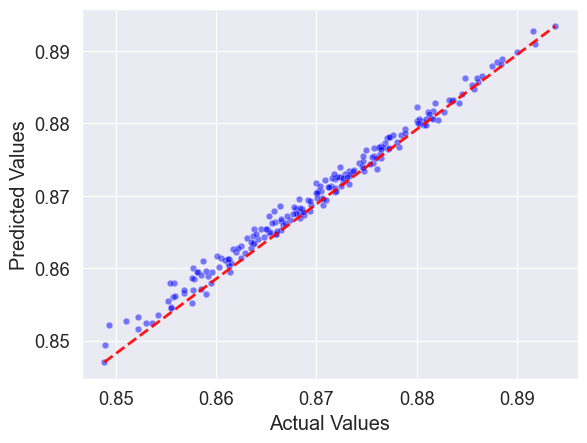

In [30]:
fig, ax = plt.subplots()
sns.set_theme(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test[:, 0:1].reshape(-1), y=y_pred.reshape(-1), color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test[:, 0:1]), max(y_test[:, 0:1])], [min(y_pred), max(y_pred)], linestyle='--', color='red', linewidth=2, alpha = 0.9)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


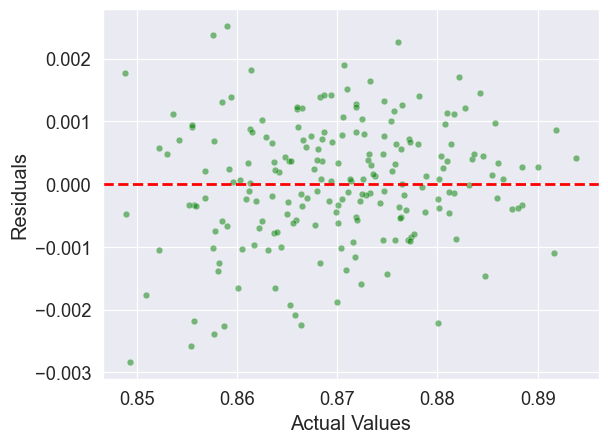

In [31]:
residuals = y_test[:, 0:1].reshape(-1) - y_pred.reshape(-1)

plt.figure()

sns.scatterplot(x=y_test[:, 0:1].reshape(-1), y=residuals.reshape(-1), color='green', alpha=0.5)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

## Hyperparameter: Size of the reference measure

In [ ]:
ref_measure_size_list = [1, 2, 3, 4, 5, 8, 9, 10, 11, 13, 15, 17, 20, 22, 25, 27, 30, 35]
size_values = []
evs_values = []
# load training data
for size in ref_measure_size_list:
    x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)

    potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_0.0001_UniformSphere_{size}_cut_1_1.npy")
    print(potentials_train.shape)

    # define transformed inputs
    X_train = np.concatenate([x_scalars, potentials_train], axis=1)
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train)

    # load test data and transform
    x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
    potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_0.0001_UniformSphere_{size}_cut_1_1.npy")

    #X_test_pca = pca.transform(potentials_test)
    X_test = np.concatenate([x_scalars, potentials_test], axis=1)
    X_test_ = scaler.transform(X_test)

    # train Gaussian process
    kernel_sinkhorn = Matern52(input_dim = size, active_dims = np.arange(2, size+2), ARD = False)
    kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
    kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
    kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
    print(f"Start GP training! With.")
    kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

    # predict
    y_pred, y_conf = kmodel.predict(X_test_)
    evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

    size_values.append(size)
    evs_values.append(evs)

ref_measure_size_list = [40, 45, 50, 60, 70, 80, 90, 100, 200, 500, 1000, 2000]
# load training data
for size in ref_measure_size_list:
    x_scalars, y_train = importing.r37_scalars(ids = train1000, test = False)

    potentials_train = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_train1000_NoSubsample_29773_epsilon_0.0001_UniformSphere_{size}_cut_1_1.npy")
    print(potentials_train.shape)

    # dimensionality reduction
    pca = PCA(n_components = 32)
    X_train_pca = pca.fit_transform(potentials_train)

    # define transformed inputs
    X_train = np.concatenate([x_scalars, X_train_pca], axis=1)
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train)

    # load test data and transform
    #test_data = load_data_fn(split="test")
    x_scalars, y_test = importing.r37_scalars(ids = test, test = True)
    potentials_test = np.load(f"Save_Sinkhorn/train1000/NoSubsample/29773/sinkhorn_potentials_test_train1000_NoSubsample_29773_epsilon_0.0001_UniformSphere_{size}_cut_1_1.npy")

    X_test_pca = pca.transform(potentials_test)
    X_test = np.concatenate([x_scalars, X_test_pca], axis=1)
    X_test_ = scaler.transform(X_test)

    # train Gaussian process
    kernel_sinkhorn = Matern52(input_dim = 32, active_dims = np.arange(2, 32+2), ARD = False)
    kernel_scalars = Matern52(input_dim = 2, active_dims = [0,1], ARD = True)
    kernel_product = kernel_sinkhorn.prod(kernel_scalars, name='productKernel')
    #kernel_product = GPy.kern.Matern52(input_dim = 34, ARD = True)
    kmodel = GPRegression(X_train_, y_train[:, 0:1], kernel_product)
    print(f"Start GP training! With.")
    kmodel.optimize_restarts(num_restarts = 5, messages = False, max_iters = 1000)

    # predict
    y_pred, y_conf = kmodel.predict(X_test_)
    evs = explained_variance_score(y_true = y_test[:, 0:1], y_pred = y_pred)

    size_values.append(size)
    evs_values.append(evs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


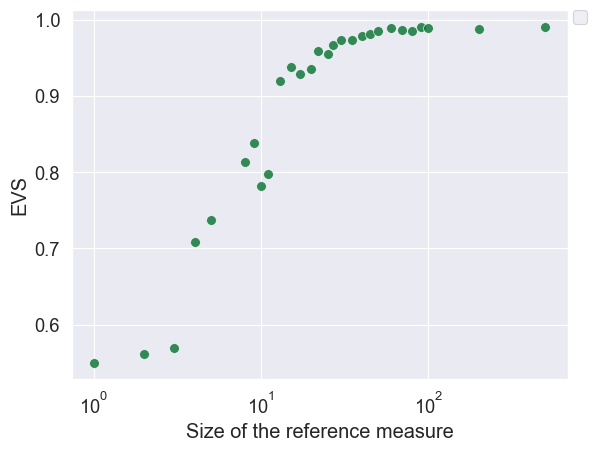

In [33]:
# plot
plt.figure()
sns.set_theme(context='paper', font_scale=1.5)
blue_palette = sns.color_palette("Greens")

sns.scatterplot(x = size_values[0:28], y = evs_values[0:28], color=blue_palette[5], s=50, alpha=0.8)

plt.xscale('log')
plt.xlabel('Size of the reference measure')
plt.ylabel('EVS')
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.savefig(f"Images/refSize_vs_evs_prez.png", bbox_inches="tight", format = "png", dpi = 400)
plt.show()